In [2]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

from nyc_taxi.db import engine



In [ ]:
#We load only model-ready data.
query = """
SELECT *
FROM features.yellow_demand_zone_hour_features
ORDER BY pu_location, hour_start
"""

df = pd.read_sql(query, engine)

df.head()


,ingest_month,hour_start,pu_location,trip_count,lag_1h,lag_24h,lag_168h,roll_6h,roll_24h,roll_168h,pickup_hour,pickup_dow,is_weekend
0,2025-01-01,2025-01-01 00:00:00,1,0,NaN,NaN,NaN,0.0,0.0,0.0,0,3,False
1,2025-01-01,2025-01-01 01:00:00,1,0,0.0,NaN,NaN,0.0,0.0,0.0,1,3,False
2,2025-01-01,2025-01-01 02:00:00,1,0,0.0,NaN,NaN,0.0,0.0,0.0,2,3,False
3,2025-01-01,2025-01-01 03:00:00,1,0,0.0,NaN,NaN,0.0,0.0,0.0,3,3,False
4,2025-01-01,2025-01-01 04:00:00,1,0,0.0,NaN,NaN,0.0,0.0,0.0,4,3,False


In [4]:
df.shape

(186739, 13)

In [5]:
df.dtypes

ingest_month            object
hour_start      datetime64[ns]
pu_location              int64
trip_count               int64
lag_1h                 float64
lag_24h                float64
lag_168h               float64
roll_6h                float64
roll_24h               float64
roll_168h              float64
pickup_hour              int64
pickup_dow               int64
is_weekend                bool
dtype: object

In [6]:
df.describe(include='all')

,ingest_month,hour_start,pu_location,trip_count,lag_1h,lag_24h,lag_168h,roll_6h,roll_24h,roll_168h,pickup_hour,pickup_dow,is_weekend
count,186739,186739,186739.000000,186739.000000,186480.000000,180523.000000,143227.000000,186739.000000,186739.000000,186739.000000,186739.00000,186739.000000,186739
unique,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,2025-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
freq,186739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,137011
mean,NaN,2025-01-15 23:59:59.999999488,133.957529,17.139018,17.149078,17.024795,16.798788,17.156155,17.028966,16.564882,11.48405,3.036061,NaN
min,NaN,2025-01-01 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,NaN
25%,NaN,2025-01-08 12:00:00,66.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.208333,0.226190,5.00000,1.000000,NaN
50%,NaN,2025-01-16 00:00:00,136.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.708333,0.720238,11.00000,3.000000,NaN
75%,NaN,2025-01-23 12:00:00,201.000000,3.000000,3.000000,3.000000,3.000000,3.666667,3.958333,3.863095,17.00000,5.000000,NaN
max,NaN,2025-01-31 00:00:00,265.000000,934.000000,934.000000,934.000000,839.000000,722.833333,423.333333,423.333333,23.00000,6.000000,NaN


In [10]:
df.isnull().sum()

ingest_month        0
hour_start          0
pu_location         0
trip_count          0
lag_1h            259
lag_24h          6216
lag_168h        43512
roll_6h             0
roll_24h            0
roll_168h           0
pickup_hour         0
pickup_dow          0
is_weekend          0
dtype: int64

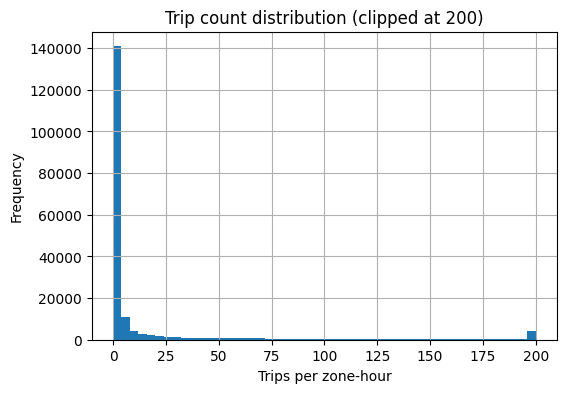

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
df["trip_count"].clip(upper=200).hist(bins=50)
plt.title("Trip count distribution (clipped at 200)")
plt.xlabel("Trips per zone-hour")
plt.ylabel("Frequency")
plt.show()


Heavy right tail → normal for demand

Many small values + zeros → Poisson / count model justified

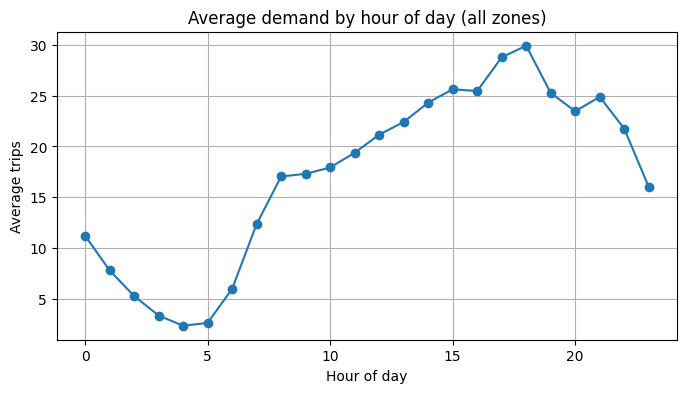

In [ ]:
#Hour-of-day demand pattern
hourly_avg = (
    df.groupby(df["hour_start"].dt.hour)["trip_count"]
      .mean()
)

plt.figure(figsize=(8,4))
hourly_avg.plot(kind="line", marker="o")
plt.title("Average demand by hour of day (all zones)")
plt.xlabel("Hour of day")
plt.ylabel("Average trips")
plt.grid(True)
plt.show()


Morning peak

Evening peak

Overnight dip

Early-morning low (≈ 3–5 AM)

Morning ramp-up (≈ 6–9 AM)

Evening peak (≈ 5–7 PM)

Late-night decline

This validates:

using hour-of-day features

using lag_24h and lag_168h

time-based forecasting is appropriate



Demand is not symmetric

Notice:
Morning peak is sharper

Evening peak is broader and higher

This tells us:

rolling averages alone will lag

same-hour-yesterday (lag_24h) should be strong

ML can potentially improve by learning asymmetry

In [13]:
#Zone sparsity check
zone_activity = (
    df.groupby("pu_location")["trip_count"]
      .mean()
      .sort_values()
)

zone_activity.head(10)


pu_location
199    0.001387
99     0.001387
187    0.002774
176    0.002774
111    0.002774
5      0.002774
245    0.004161
156    0.004161
204    0.004161
109    0.005548
Name: trip_count, dtype: float64

In [14]:
top_zone = (
    df.groupby("pu_location")["trip_count"]
      .sum()
      .sort_values(ascending=False)
      .index[0]
)

top_zone

np.int64(161)

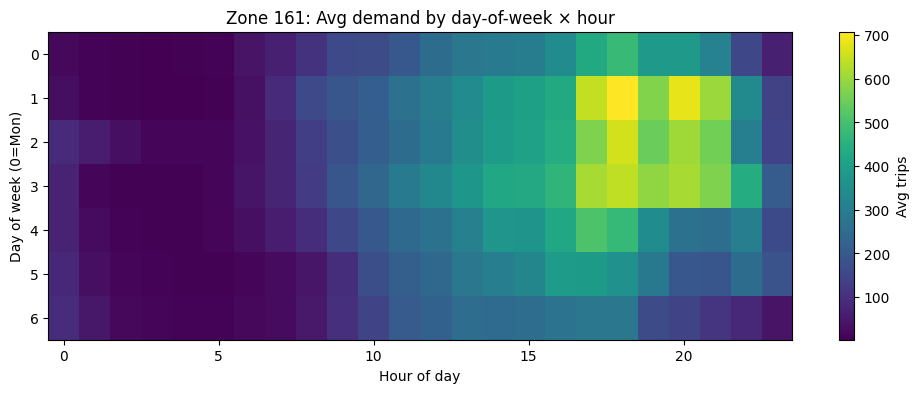

In [15]:
#Heatmap
zone_df = df[df["pu_location"] == top_zone].copy()

zone_df["hour"] = zone_df["hour_start"].dt.hour
zone_df["dow"] = zone_df["hour_start"].dt.dayofweek

pivot = (
    zone_df.pivot_table(
        index="dow",
        columns="hour",
        values="trip_count",
        aggfunc="mean"
    )
)

plt.figure(figsize=(12,4))
plt.imshow(pivot, aspect="auto", cmap="viridis")
plt.colorbar(label="Avg trips")
plt.title(f"Zone {top_zone}: Avg demand by day-of-week × hour")
plt.xlabel("Hour of day")
plt.ylabel("Day of week (0=Mon)")
plt.show()


In [17]:
split_time = pd.Timestamp("2025-01-25")

train = df[df["hour_start"] < split_time]
valid = df[df["hour_start"] >= split_time]

print("Train rows:", len(train))
print("Valid rows:", len(valid))

Train rows: 149184
Valid rows: 37555


In [18]:
y_valid = valid["trip_count"]


In [19]:
y_pred_lag24 = valid["lag_24h"]

mask = y_pred_lag24.notna()

mae_24 = mean_absolute_error(y_valid[mask], y_pred_lag24[mask])
rmse_24 = np.sqrt(mean_squared_error(y_valid[mask], y_pred_lag24[mask]))

print("Baseline: lag_24h")
print("MAE :", mae_24)
print("RMSE:", rmse_24)


Baseline: lag_24h
MAE : 6.485341499134603
RMSE: 26.495720270465924


In [20]:
y_pred_roll24 = valid["roll_24h"]
mask = y_pred_roll24.notna()

mae_roll = mean_absolute_error(y_valid[mask], y_pred_roll24[mask])
rmse_roll = np.sqrt(mean_squared_error(y_valid[mask], y_pred_roll24[mask]))

print("Baseline: rolling_24h")
print("MAE :", mae_roll)
print("RMSE:", rmse_roll)


Baseline: rolling_24h
MAE : 11.70853414991346
RMSE: 36.557051003556055


In [21]:
pd.DataFrame({
    "model": ["lag_24h", "rolling_24h"],
    "MAE": [mae_24, mae_roll],
    "RMSE": [rmse_24, rmse_roll]
})


,model,MAE,RMSE
0,lag_24h,6.485341,26.495720
1,rolling_24h,11.708534,36.557051


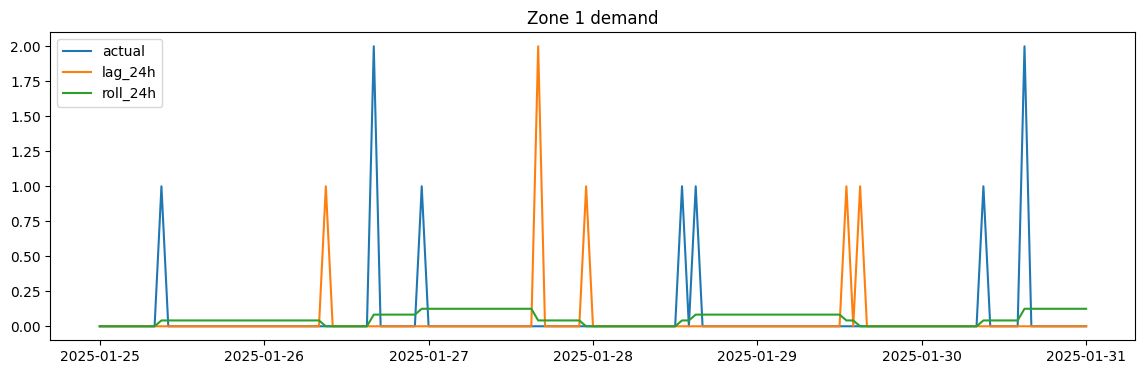

In [22]:
zone_id = valid["pu_location"].iloc[0]

tmp = valid[valid["pu_location"] == zone_id].iloc[:200]

plt.figure(figsize=(14,4))
plt.plot(tmp["hour_start"], tmp["trip_count"], label="actual")
plt.plot(tmp["hour_start"], tmp["lag_24h"], label="lag_24h")
plt.plot(tmp["hour_start"], tmp["roll_24h"], label="roll_24h")
plt.legend()
plt.title(f"Zone {zone_id} demand")
plt.show()


In [30]:
FEATURES = [
    "lag_1h",
    "lag_24h",
    "lag_168h",
    "pickup_hour",
    "pickup_dow",
    "is_weekend",
    "pu_location"
]

TARGET = "trip_count"


In [40]:
def make_X(df_in: pd.DataFrame, train_columns=None):
    X = pd.get_dummies(df_in[FEATURES], columns=["pu_location"], drop_first=True)
    if train_columns is not None:
        X = X.reindex(columns=train_columns, fill_value=0)
    return X


In [42]:
#Drop rows where lags are missing (early hours):
train_ml = train.dropna(subset=FEATURES + [TARGET])
valid_ml = valid.dropna(subset=FEATURES + [TARGET])

X_train = make_X(train_ml)
# X_train = train_ml[FEATURES]
y_train = train_ml[TARGET]

X_valid = make_X(valid_ml, train_columns=X_train.columns)
# X_valid = valid_ml[FEATURES]
y_valid = valid_ml[TARGET]


In [43]:
X_train = pd.get_dummies(train_ml[FEATURES], columns=["pu_location"], drop_first=True)
X_valid = pd.get_dummies(valid_ml[FEATURES], columns=["pu_location"], drop_first=True)

# align columns
X_valid = X_valid.reindex(columns=X_train.columns, fill_value=0)


In [44]:
from sklearn.linear_model import PoissonRegressor

model = PoissonRegressor(
    alpha=1e-4,        # no regularization for now
    max_iter=2000
)

model.fit(X_train, y_train)


,"alpha alpha: float, default=1Constant that multiplies the L2 penalty term and determines theregularization strength. ``alpha = 0`` is equivalent to unpenalizedGLMs. In this case, the design matrix `X` must have full column rank(no collinearities).Values of `alpha` must be in the range `[0.0, inf)`.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the linear predictor (`X @ coef + intercept`).",True
,"solver solver: {'lbfgs', 'newton-cholesky'}, default='lbfgs'Algorithm to use in the optimization problem:'lbfgs' Calls scipy's L-BFGS-B optimizer.'newton-cholesky' Uses Newton-Raphson steps (in arbitrary precision arithmetic equivalent to iterated reweighted least squares) with an inner Cholesky based solver. This solver is a good choice for `n_samples` >> `n_features`, especially with one-hot encoded categorical features with rare categories. Be aware that the memory usage of this solver has a quadratic dependency on `n_features` because it explicitly computes the Hessian matrix. .. versionadded:: 1.2",'lbfgs'
,"max_iter max_iter: int, default=100The maximal number of iterations for the solver.Values must be in the range `[1, inf)`.",2000
,"tol tol: float, default=1e-4Stopping criterion. For the lbfgs solver,the iteration will stop when ``max{|g_j|, j = 1, ..., d} <= tol``where ``g_j`` is the j-th component of the gradient (derivative) ofthe objective function.Values must be in the range `(0.0, inf)`.",0.0001
,"warm_start warm_start: bool, default=FalseIf set to ``True``, reuse the solution of the previous call to ``fit``as initialization for ``coef_`` and ``intercept_`` .",False
,"verbose verbose: int, default=0For the lbfgs solver set verbose to any positive number for verbosity.Values must be in the range `[0, inf)`.",0


In [45]:
y_pred = model.predict(X_valid)

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_valid, y_pred)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))

print("Poisson Regression")
print("MAE :", mae)
print("RMSE:", rmse)


Poisson Regression
MAE : 28.495943176142024
RMSE: 56.39738103027582


In [48]:
baseline_pred = valid_ml["lag_24h"]

mae_base = mean_absolute_error(y_valid, baseline_pred)
rmse_base = np.sqrt(mean_squared_error(y_valid, baseline_pred))

pd.DataFrame({
    "Model": ["Lag 24h baseline", "Poisson (zone one-hot)"],
    "MAE": [mae_base, mae],
    "RMSE": [rmse_base, rmse]
})


,Model,MAE,RMSE
0,Lag 24h baseline,6.485341,26.495720
1,Poisson (zone one-hot),28.495943,56.397381


In [38]:
coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coefficient": model.coef_
}).sort_values("coefficient", ascending=False)

coef_df.head(30)


,feature,coefficient
0,lag_1h,0.0
181,pu_location_183,0.0
167,pu_location_169,0.0
168,pu_location_170,0.0
169,pu_location_171,0.0
170,pu_location_172,0.0
171,pu_location_173,0.0
172,pu_location_174,0.0
173,pu_location_175,0.0
174,pu_location_176,0.0


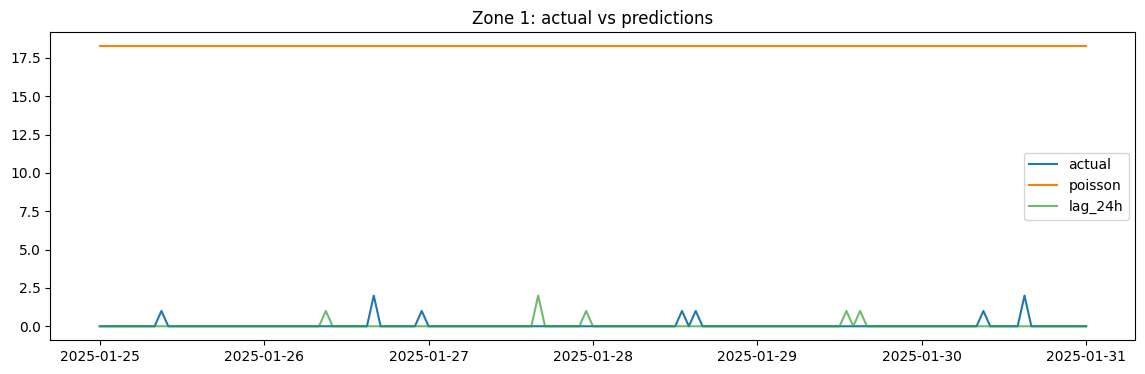

In [49]:
sample_zone = 1
tmp = valid_ml[valid_ml["pu_location"] == sample_zone].iloc[:200].copy()

X_tmp = make_X(tmp, train_columns=X_train.columns)
tmp_pred = model.predict(X_tmp)

import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))
plt.plot(tmp["hour_start"], tmp["trip_count"], label="actual")
plt.plot(tmp["hour_start"], tmp_pred, label="poisson")
plt.plot(tmp["hour_start"], tmp["lag_24h"], label="lag_24h", alpha=0.7)
plt.legend()
plt.title(f"Zone {sample_zone}: actual vs predictions")
plt.show()


In [ ]:
FEATURES = [
    "lag_1h",
    "lag_24h",
    "lag_168h",
    "roll_6h",
    "roll_24h",
    "roll_168h",
    "pickup_hour",
    "pickup_dow",
    "is_weekend",
    "pu_location",
]
TARGET = "trip_count"

train_ml = train.dropna(subset=FEATURES + [TARGET]).copy()
valid_ml = valid.dropna(subset=FEATURES + [TARGET]).copy()

X_train = train_ml[FEATURES]
y_train = train_ml[TARGET]

X_valid = valid_ml[FEATURES]
y_valid = valid_ml[TARGET]


In [51]:
from sklearn.ensemble import HistGradientBoostingRegressor

gbr = HistGradientBoostingRegressor(
    loss="poisson",       # perfect for counts
    learning_rate=0.05,
    max_depth=8,
    max_leaf_nodes=63,
    min_samples_leaf=50,
    l2_regularization=1e-4,
    max_iter=300,
    random_state=42
)

gbr.fit(X_train, y_train)


,"loss loss: {'squared_error', 'absolute_error', 'gamma', 'poisson', 'quantile'}, default='squared_error'The loss function to use in the boosting process. Note that the""squared error"", ""gamma"" and ""poisson"" losses actually implement""half least squares loss"", ""half gamma deviance"" and ""half poissondeviance"" to simplify the computation of the gradient. Furthermore,""gamma"" and ""poisson"" losses internally use a log-link, ""gamma""requires ``y > 0`` and ""poisson"" requires ``y >= 0``.""quantile"" uses the pinball loss... versionchanged:: 0.23 Added option 'poisson'... versionchanged:: 1.1 Added option 'quantile'... versionchanged:: 1.3 Added option 'gamma'.",'poisson'
,"quantile quantile: float, default=NoneIf loss is ""quantile"", this parameter specifies which quantile to be estimatedand must be between 0 and 1.",None
,"learning_rate learning_rate: float, default=0.1The learning rate, also known as *shrinkage*. This is used as amultiplicative factor for the leaves values. Use ``1`` for noshrinkage.",0.05
,"max_iter max_iter: int, default=100The maximum number of iterations of the boosting process, i.e. themaximum number of trees.",300
,"max_leaf_nodes max_leaf_nodes: int or None, default=31The maximum number of leaves for each tree. Must be strictly greaterthan 1. If None, there is no maximum limit.",63
,"max_depth max_depth: int or None, default=NoneThe maximum depth of each tree. The depth of a tree is the number ofedges to go from the root to the deepest leaf.Depth isn't constrained by default.",8
,"min_samples_leaf min_samples_leaf: int, default=20The minimum number of samples per leaf. For small datasets with lessthan a few hundred samples, it is recommended to lower this valuesince only very shallow trees would be built.",50
,"l2_regularization l2_regularization: float, default=0The L2 regularization parameter penalizing leaves with small hessians.Use ``0`` for no regularization (default).",0.0001
,"max_features max_features: float, default=1.0Proportion of randomly chosen features in each and every node split.This is a form of regularization, smaller values make the trees weakerlearners and might prevent overfitting.If interaction constraints from `interaction_cst` are present, only allowedfeatures are taken into account for the subsampling... versionadded:: 1.4",1.0
,"max_bins max_bins: int, default=255The maximum number of bins to use for non-missing values. Beforetraining, each feature of the input array `X` is binned intointeger-valued bins, which allows for a much faster training stage.Features with a small number of unique values may use less than``max_bins`` bins. In addition to the ``max_bins`` bins, one more binis always reserved for missing values. Must be no larger than 255.",255
,"categorical_features categorical_features: array-like of {bool, int, str} of shape (n_features) or shape (n_categorical_features,), default='from_dtype'Indicates the categorical features.- None : no feature will be considered categorical.- boolean array-like : boolean mask indicating categorical features.- integer array-like : integer indices indicating categorical features.- str array-like: names of categorical features (assuming the training data has feature names).- `""from_dtype""`: dataframe columns with dtype ""category"" are considered to be categorical features. The input must be an object exposing a ``__dataframe__`` method such as pandas or polars DataFrames to use this feature.For each categorical feature, there must be at most `max_bins` uniquecategories. Negative values for categorical features encoded as numericdtypes are treated as missing values. All categorical values areconverted to floating point numbers. This means that categorical valuesof 1.0 and 1 are treated as the same category.Read more in the :ref:`User Guide ` and:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_categorical.py`... versionadded:: 0.24.. versionchanged:: 1.2 Added support for feature names... versionchanged:: 1.4 A

In [52]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

pred = gbr.predict(X_valid)

mae_gbr = mean_absolute_error(y_valid, pred)
rmse_gbr = np.sqrt(mean_squared_error(y_valid, pred))

baseline_pred = valid_ml["lag_24h"]
mae_base = mean_absolute_error(y_valid, baseline_pred)
rmse_base = np.sqrt(mean_squared_error(y_valid, baseline_pred))

pd.DataFrame({
    "Model": ["Lag 24h baseline", "HistGB (poisson loss)"],
    "MAE": [mae_base, mae_gbr],
    "RMSE": [rmse_base, rmse_gbr],
})


,Model,MAE,RMSE
0,Lag 24h baseline,6.485341,26.495720
1,HistGB (poisson loss),3.435158,12.018301


In [53]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

pred = gbr.predict(X_valid)

mae_gbr = mean_absolute_error(y_valid, pred)
rmse_gbr = np.sqrt(mean_squared_error(y_valid, pred))

baseline_pred = valid_ml["lag_24h"]
mae_base = mean_absolute_error(y_valid, baseline_pred)
rmse_base = np.sqrt(mean_squared_error(y_valid, baseline_pred))

pd.DataFrame({
    "Model": ["Lag 24h baseline", "HistGB (poisson loss)"],
    "MAE": [mae_base, mae_gbr],
    "RMSE": [rmse_base, rmse_gbr],
})


,Model,MAE,RMSE
0,Lag 24h baseline,6.485341,26.495720
1,HistGB (poisson loss),3.435158,12.018301


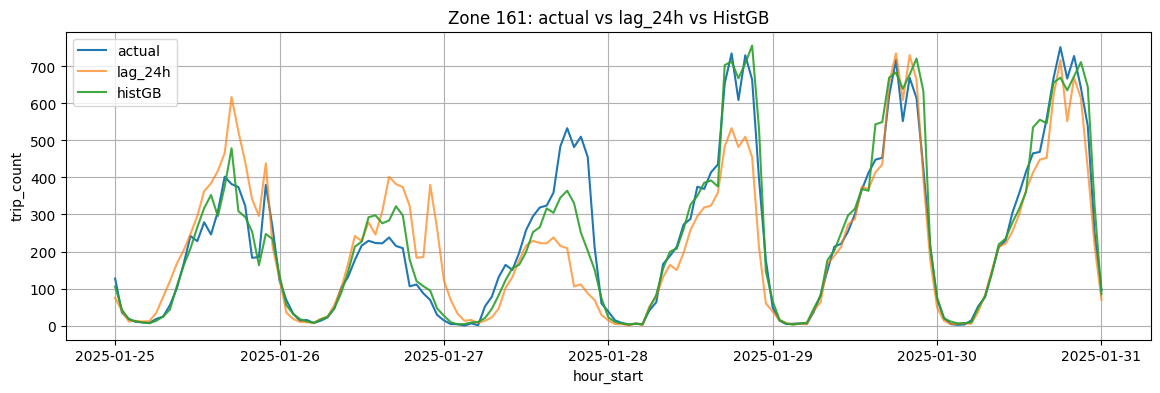

In [54]:
import matplotlib.pyplot as plt

# choose a zone that actually has activity (avoid ultra-sparse zones like zone 1)
top_zones = (
    valid_ml.groupby("pu_location")["trip_count"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

zone_id = int(top_zones[0])
tmp = valid_ml[valid_ml["pu_location"] == zone_id].sort_values("hour_start").iloc[:240].copy()

tmp_pred = gbr.predict(tmp[FEATURES])

plt.figure(figsize=(14,4))
plt.plot(tmp["hour_start"], tmp["trip_count"], label="actual")
plt.plot(tmp["hour_start"], tmp["lag_24h"], label="lag_24h", alpha=0.7)
plt.plot(tmp["hour_start"], tmp_pred, label="histGB", alpha=0.9)
plt.legend()
plt.title(f"Zone {zone_id}: actual vs lag_24h vs HistGB")
plt.xlabel("hour_start")
plt.ylabel("trip_count")
plt.grid(True)
plt.show()
